In [1]:
import cv2 
import argparse

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import datasets
import util.misc as utils
from models import build_model
import datasets.transforms as T

In [2]:
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr_backbone', default=1.00e-5, type=float)
    parser.add_argument('--batch_size', default=1, type=int, choices=[1])

    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--resume', default='/home/paul.1164/Paul/INTR_V2/intr_checkpoint_cub_detr_r50.pth',
                        help='resume from checkpoint')
    
    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer") #default=0.1
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=200, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # # * Dataset parameters
    parser.add_argument('--dataset_name', default='cub') 

    # * Device parameters
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    
    return parser

In [3]:
data_mean_std = {
    "cub": (
        torch.tensor([0.485, 0.456, 0.406]),
        torch.tensor([0.229, 0.224, 0.225]),
    ),
}

class SingleImageDataset:
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.image_path).convert('RGB')

        target = {}
        target["file_name"] = [str(self.image_path)]
        target["image_label"] = torch.tensor([0000], dtype=torch.int64)  # Set the target label as needed

        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return 1  

def make_transforms():
    mean, std = data_mean_std["cub"]

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
    return T.Compose([
        T.RandomResize([800], max_size=1333),
        normalize,
    ])

def build_single_image_dataset(image_path):
    transform = make_transforms()
    dataset = SingleImageDataset(image_path=image_path, transform=transform)
    return dataset

def image_preprocessing(image_path):
    single_image_dataset = build_single_image_dataset(image_path)
    sampler_val = torch.utils.data.SequentialSampler(single_image_dataset)
    data_loader_val = DataLoader(single_image_dataset, args.batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=1) 
    return data_loader_val

In [4]:
def load_model(args, model):
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    return model

In [5]:
@torch.no_grad()
def predicted_class(output, topk=(1,)):
    query_logits = output['query_logits']
    batch_size = query_logits.size(0)
    
    maxk = min(max(topk), query_logits.size(1))
    _, pred = query_logits.topk(maxk, dim=1, largest=True, sorted=True)
    return pred

In [6]:
def get_class_name(number, filename="demo_image/classes.txt"):
    with open(filename, "r") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.strip().split(" ", 1)
        if parts[0] == str(number):
            class_name = parts[1]
            break
    else:
        return f"No class found for number {number}"

    class_name_parts = class_name.split(".")
    modified_name = " ".join(part.capitalize() for part in class_name_parts[1].split("_"))

    return modified_name


In [7]:
def SuperImposeHeatmap(attention, input_image):
    alpha=0.5
    avg_heatmap_resized = cv2.resize(attention, (input_image.shape[1], input_image.shape[0]), interpolation=cv2.INTER_CUBIC)
    avg_normalized_heatmap = (avg_heatmap_resized - np.min(avg_heatmap_resized)) / (np.max(avg_heatmap_resized) - np.min(avg_heatmap_resized))
    heatmap = (avg_normalized_heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.medianBlur(heatmap,15)
    heatmap =  cv2.GaussianBlur(heatmap, (15, 15), 0)
    result = (input_image *alpha  + heatmap * (1-alpha)).astype(np.uint8)
    return result

In [8]:
def visualization(args, image_path, query_index, attention_scores, encoder_output):

    attention_score = attention_scores[5, :, :, :, :] # sixth layer of the decoder
    attention_score_pred_query = attention_score[:, :, query_index, :] # query corresponding to predicted class 

    # Load and resize the original image
    input_image = cv2.imread(image_path)
    input_image = cv2.resize(input_image, (0, 0), fx=0.8, fy=0.8)

    # Create a subplot grid for the original image and visualizations
    num_heads = attention_score_pred_query.shape[1] + 1  
    rows = 1
    cols = num_heads // rows

    # Plot the original image
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes[0].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')

    for head_index in range(attention_score_pred_query.shape[1]):
        heatmap_head = attention_score_pred_query[:, head_index, :].reshape(encoder_output.shape[2], encoder_output.shape[3]).detach().cpu().numpy()
        result = SuperImposeHeatmap(heatmap_head, input_image)

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1:
            ax = axes[head_index + 1]
        elif cols == 1:
            ax = axes[head_index + 1]
        else:
            ax = axes[(head_index + 1) // cols, (head_index + 1) % cols]

        ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        ax.axis('off')

    plt.tight_layout()
    plt.show()


/home/paul.1164/anaconda3/envs/extr/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paul.1164/anaconda3/envs/extr/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Species predicted by INTR is: Painted Bunting 



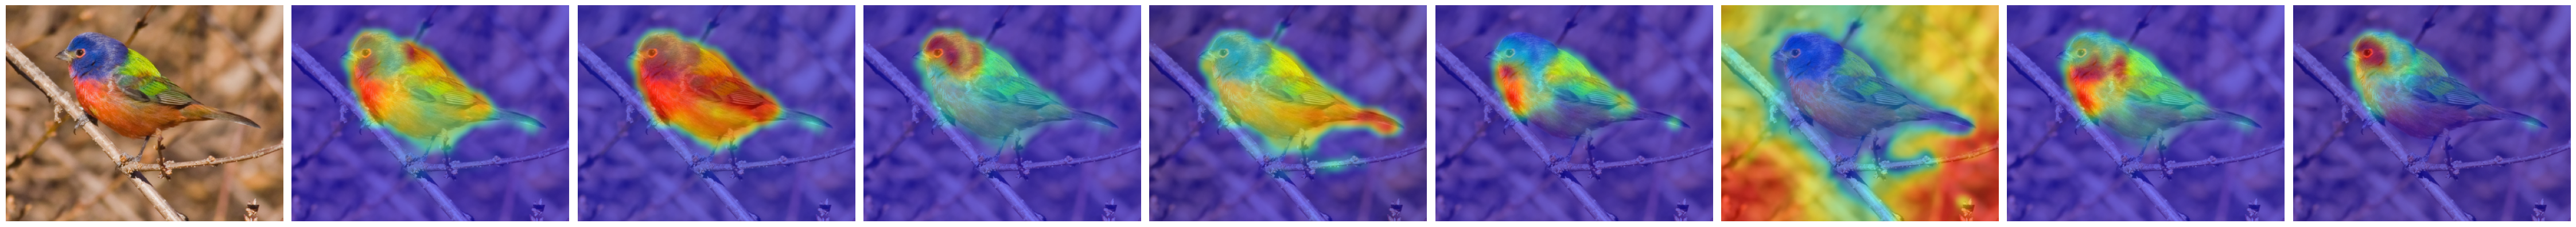

Test:  [0/1]  eta: 0:00:03    time: 3.0107  data: 0.2935  max mem: 921
Test: Total time: 0:00:03 (3.0709 s / it)


In [9]:
def main(args):
    
    image_path = "demo_image/Painted_Bunting_0004_16641.jpg"
    
    test_image_loader=image_preprocessing(image_path)

    device = torch.device(args.device)
    model, _ = build_model(args)
    model.to(device)
    model=load_model(args, model)
    model.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    for samples, targets in metric_logger.log_every(test_image_loader, 1, header):
        samples = samples.to(device)
    
        outputs, encoder_output, _, attention_scores, avg_attention_scores = model(samples)
        pred_class_index=predicted_class(outputs, topk=(1, 1))
        print ("Species predicted by INTR is:",get_class_name(int(pred_class_index[0][0])+1), "\n")

        visualization(args, image_path, int(pred_class_index[0][0]), attention_scores, encoder_output)

if __name__ == '__main__':
    parser = argparse.ArgumentParser('INTR interpretation visualization script', parents=[get_args_parser()])
    args = parser.parse_args(args=[])
    main(args)